In [7]:
from model import DenoisingUNet
from utils import *
from data import synthetic_mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch
import numpy as np
sampleRate = 49.95

# Training on synthetic data

In [8]:
N_sub = 32
batch_size = 32
hidden_layers = 4
learning_rate = 5e-4
num_epochs = 1000

In [9]:
train_dataset = synthetic_mask_dataset(data_path='synthetic-data/train', f_min=1, f_max=10, N_sub=N_sub,augment=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [10]:
val_dataset = synthetic_mask_dataset(data_path = 'synthetic-data/test', f_min=1, f_max=10, N_sub=N_sub,augment=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

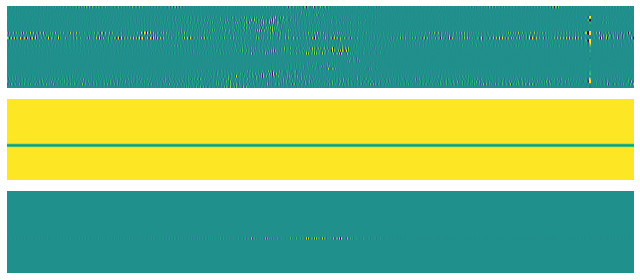

In [11]:
for eval,masks in train_loader:
    break
# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

# Show sample (without blanking)
axes[0].imshow(eval[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

# Show mask
axes[1].imshow(masks[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

masked_sample = eval*(1-masks)
# Show prediction target
axes[2].imshow(masked_sample[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


In [7]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in train_loader:
        eval_samples = eval_samples[:,:,32:]        
        mask = mask[:,:,32:]
        # to GPU
        mask = mask.to(device)
        eval_samples = eval_samples.to(device)
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        # complementary mask
        c_mask = (1-mask).squeeze()

        optimizer.zero_grad()
        # apply complementary mask to output (proj. operator)
        output = model(sample).squeeze()*c_mask
        truth = (eval_samples.squeeze()*c_mask).squeeze()
        loss = criterion(output.squeeze(), truth)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in val_loader:
            eval_samples = eval_samples[:,:,32:]        
            mask = mask[:,:,32:]
            # to GPU
            mask = mask.to(device)
            eval_samples = eval_samples.to(device)
            # apply mask
            sample = eval_samples * mask.clone().detach()
            sample = torch.unsqueeze(sample.squeeze(), 1)
            # complementary mask
            c_mask = (1-mask).squeeze()

            optimizer.zero_grad()
            # apply complementary mask to output (proj. operator)
            output = model(sample).squeeze()*c_mask
            truth = (eval_samples.squeeze()*c_mask).squeeze()
            loss = criterion(output.squeeze(), truth)
        eval_losses.append(loss.item())
        epochs_losses_val.append(np.mean(eval_losses))
    if epoch % 99 == 0:
        print(f"Epoch: {epoch} Training Loss: {np.mean(batch_losses)}, Validation Loss: {np.mean(eval_losses)}")
    

Epoch: 0 Training Loss: 0.03879443866511186, Validation Loss: 0.03895075246691704
Epoch: 99 Training Loss: 0.03055956183622281, Validation Loss: 0.030697176232933998
Epoch: 198 Training Loss: 0.030348552390933037, Validation Loss: 0.030510442331433296
Epoch: 297 Training Loss: 0.030202847595016163, Validation Loss: 0.030801838263869286
Epoch: 396 Training Loss: 0.030132291838526726, Validation Loss: 0.030808905139565468
Epoch: 495 Training Loss: 0.029612920247018337, Validation Loss: 0.031392745673656464
Epoch: 594 Training Loss: 0.02906087351342042, Validation Loss: 0.030955541878938675
Epoch: 693 Training Loss: 0.028431353780130546, Validation Loss: 0.03144242241978645
Epoch: 792 Training Loss: 0.02818429097533226, Validation Loss: 0.03151825815439224
Epoch: 891 Training Loss: 0.027851724065840244, Validation Loss: 0.0317947119474411
Epoch: 990 Training Loss: 0.027399199704329174, Validation Loss: 0.03185370936989784


Text(0.5, 1.0, 'Validation MSE')

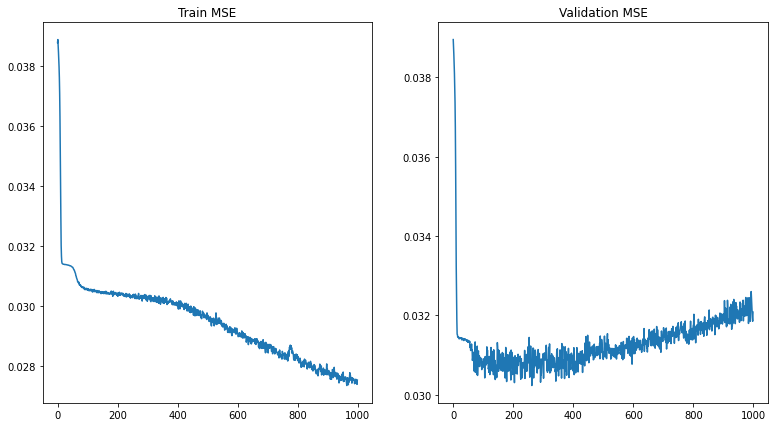

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13, 7))
ax1.plot(epochs_losses_train)
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val)
ax2.set_title("Validation MSE")

In [9]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new_model_tests\\synthetic-train-1000.pth")


# Testing on synthetic data

In [10]:
model.eval().to(torch.device('cpu'));

In [13]:
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/synthetic-train-1000.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();

In [14]:
# Reconstruct just one file
eval_sample = np.load('synthetic-data\\test\\waveforms-test.npy')[:,32:]
N_ch = eval_sample.shape[0]
N_t = eval_sample.shape[1]

""" Prepare samples and masks """
masks = np.ones((N_ch, N_sub, N_t))
eval_samples = np.zeros_like(masks)

gutter = N_sub // 2
mid = N_sub // 2

for i in range(gutter):
    masks[i, i] = 0
    eval_samples[i, :, :] = eval_sample[:N_sub]

for i in range(gutter, N_ch - gutter):
    start = i - mid
    stop = i + mid if N_sub % 2 == 0 else i + mid + 1

    masks[i, mid] = 0
    eval_samples[i, :, :] = eval_sample[start:stop]

for i in range(N_ch - gutter, N_ch):
    masks[i, i - N_ch] = 0
    eval_samples[i, :, :] = eval_sample[-N_sub:]

sample = eval_samples * masks
sample = torch.unsqueeze(torch.Tensor(sample).squeeze(), 1)
c_mask = (1-masks)
output = model(sample).detach().squeeze()*c_mask
output = output.sum(axis=1)


In [15]:
output_ = taper_filter(output, 1, 10, sampleRate)

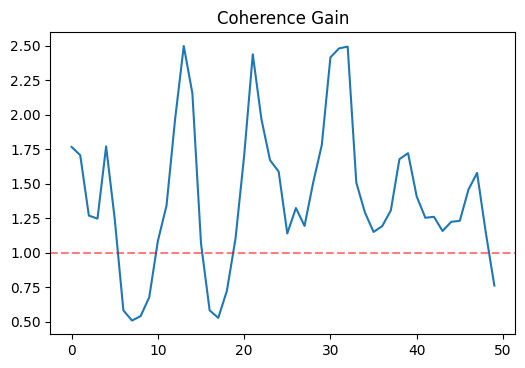

In [16]:
og = np.array(eval_sample)
rec = np.array(output_)
bin_size = 5
cc_og = compute_moving_coherence(og, bin_size)
cc_rec = compute_moving_coherence(rec, bin_size)
cc_gain = cc_rec / cc_og
plt.figure(dpi=100)
plt.plot(cc_gain)
plt.title("Coherence Gain")
plt.axhline(y=1,linestyle='--',alpha=0.5,color='r')

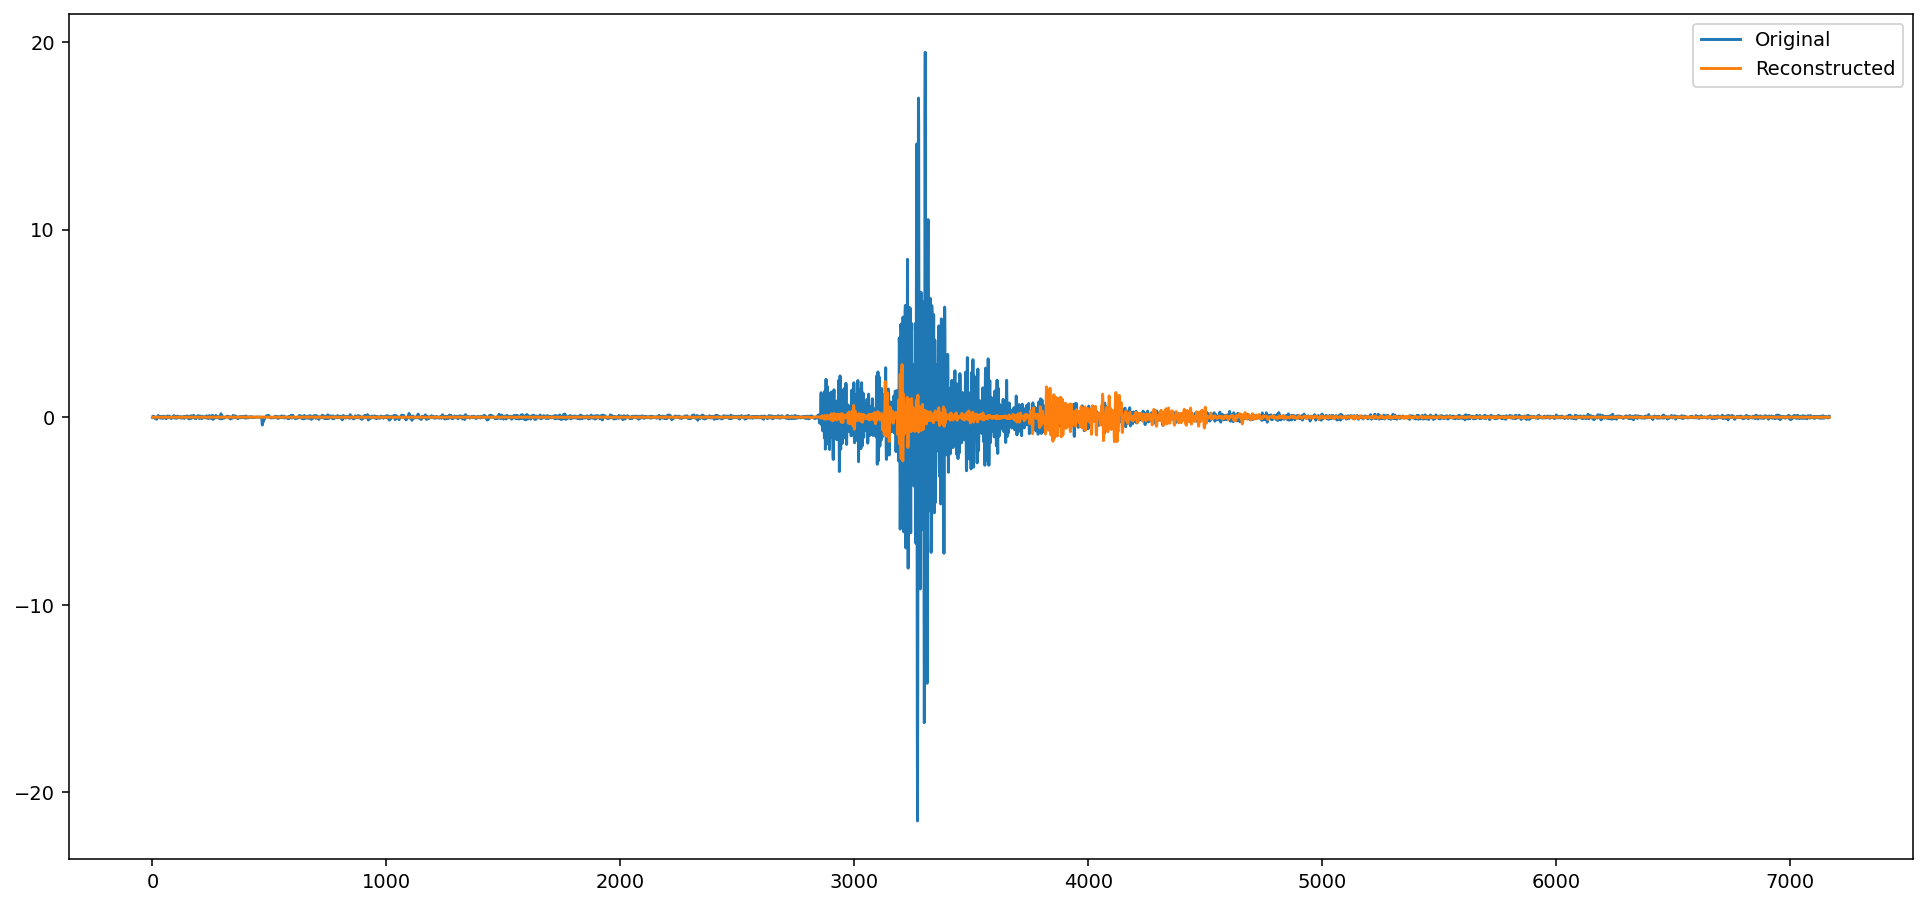

In [17]:
channel=10
plt.figure(figsize=(17,8),dpi=140)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()

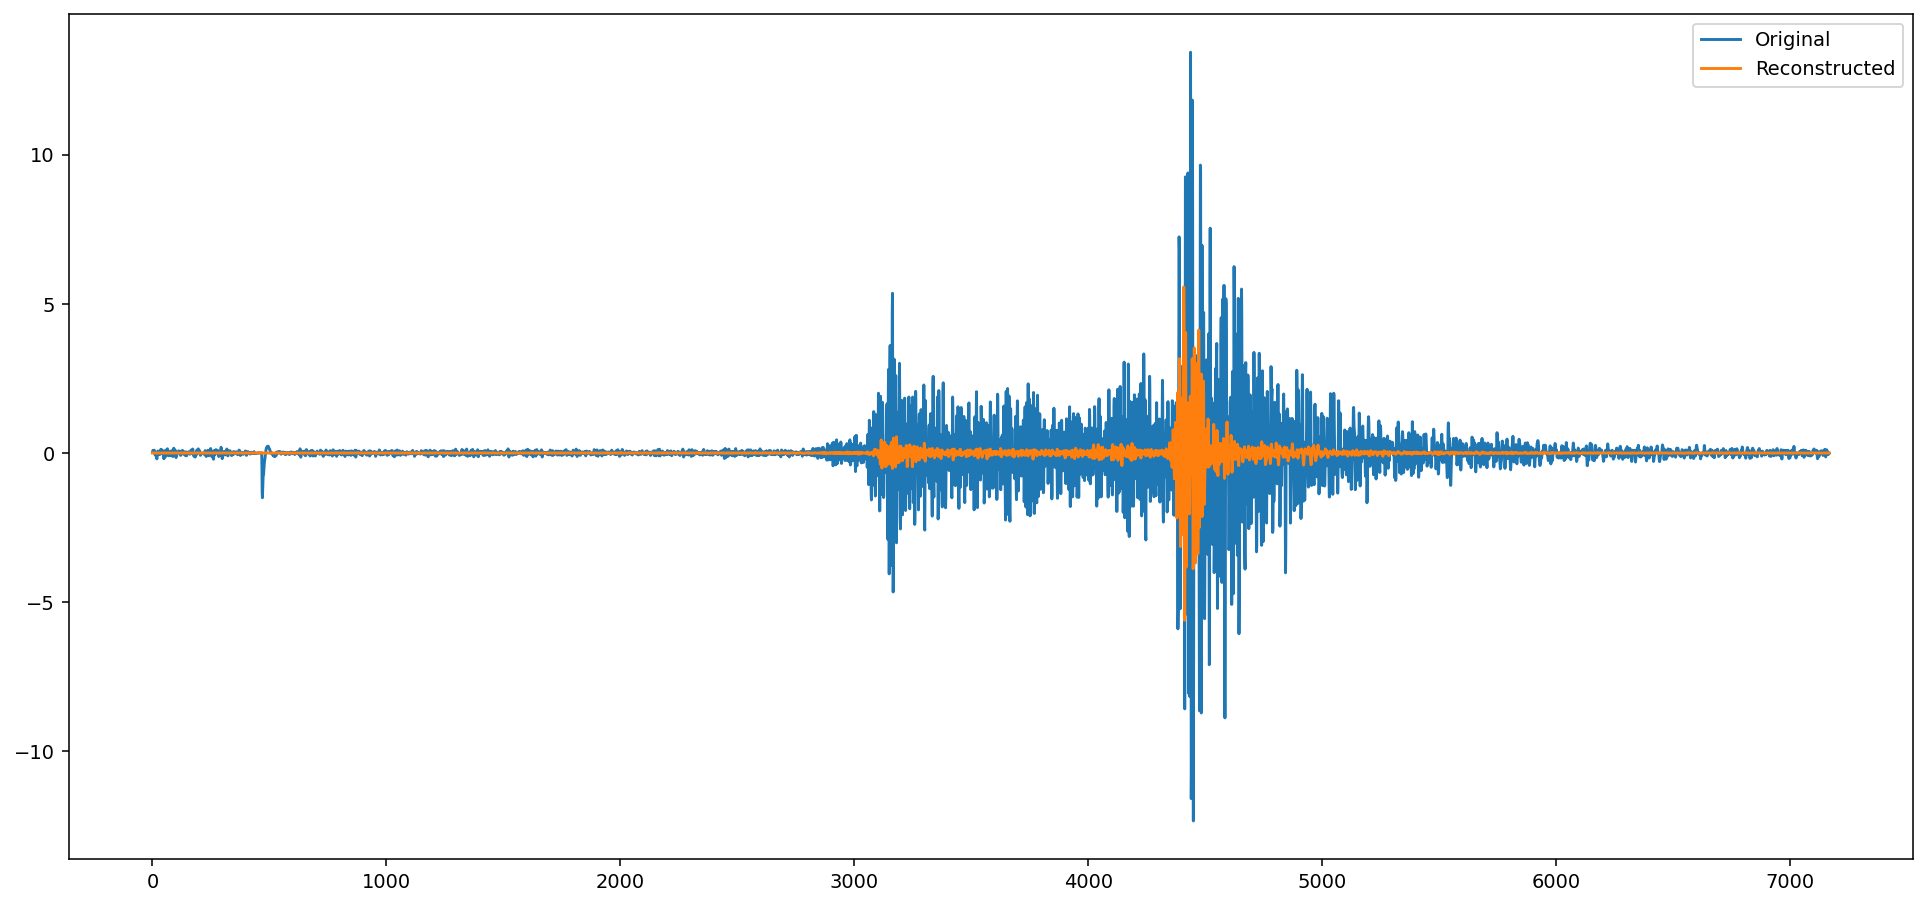

In [20]:
channel=0
plt.figure(figsize=(17,8),dpi=140)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()

In [12]:
np.mean((og-rec)**2)/np.mean((og)**2)

1.0071899667226485